# AMSC698K Homework 10
##### Elijah Kin & Noorain Noorani

In [26]:
%%capture

# Run VQE notebook to get Pauli decomposition function
%run VQE_AHO.ipynb

In [2]:
import numpy as np

### Problem A
1. The Hadamard Test circuit takes a qubit $q_0$, prepared as $|+\rangle$, and state $|\psi\rangle \in \mathbb{C}^n$ and applies to it the controlled unitary CU. Describe how this test works and what the measurement of $q_0$ tells us about $U |\psi\rangle$. 

2. In the VQLS algorithm the Hadamard Test is applied in a modified form since two controlled unitaries are provided for the test. Describe how this test results in an "overlap probability" (or cosine similarity, a central measure in NLP).

In [3]:
# TODO

### Problem B
1. Suppose a LSE, decomposed into quantum gates, is given by:
$$ A = \mathbb{I} + 0.2 X_0 Z_1 + 0.2 X_0; \quad |b\rangle = H_0 H_1 H_2 |0\rangle $$
Apply the VQLS algorithm and compare with classical solutions using $\texttt{scipy.linalg.solve()}$ and $\texttt{scipy.linalg.inv()}$.

In [1]:
# Pennylane
import pennylane as qml
from pennylane import numpy as np

# Plotting
import matplotlib.pyplot as plt

In [2]:
n_qubits = 3  # Number of system qubits.
n_shots = 10 ** 6  # Number of quantum measurements.
tot_qubits = n_qubits + 1  # Addition of an ancillary qubit.
ancilla_idx = n_qubits  # Index of the ancillary qubit (last position).
steps = 30  # Number of optimization steps
eta = 0.8  # Learning rate
q_delta = 0.001  # Initial spread of random quantum weights
rng_seed = 0  # Seed for random number generator

In [3]:
# Coefficients of the linear combination A = c_0 A_0 + c_1 A_1 ...
c = np.array([1.0, 0.2, 0.2])

def U_b():
    """Unitary matrix rotating the ground state to the problem vector |b> = U_b |0>."""
    for idx in range(n_qubits):
        qml.Hadamard(wires=idx)

def CA(idx):
    """Controlled versions of the unitary components A_l of the problem matrix A."""
    if idx == 0:
        # Identity operation
        None

    elif idx == 1:
        qml.CNOT(wires=[ancilla_idx, 0])
        qml.CZ(wires=[ancilla_idx, 1])

    elif idx == 2:
        qml.CNOT(wires=[ancilla_idx, 0])

In [4]:
def variational_block(weights):
    """Variational circuit mapping the ground state |0> to the ansatz state |x>."""
    # We first prepare an equal superposition of all the states of the computational basis.
    for idx in range(n_qubits):
        qml.Hadamard(wires=idx)

    # A very minimal variational circuit.
    for idx, element in enumerate(weights):
        qml.RY(element, wires=idx)

In [5]:
dev_mu = qml.device("lightning.qubit", wires=tot_qubits)

@qml.qnode(dev_mu, interface="autograd")
def local_hadamard_test(weights, l=None, lp=None, j=None, part=None):

    # First Hadamard gate applied to the ancillary qubit.
    qml.Hadamard(wires=ancilla_idx)

    # For estimating the imaginary part of the coefficient "mu", we must add a "-i"
    # phase gate.
    if part == "Im" or part == "im":
        qml.PhaseShift(-np.pi / 2, wires=ancilla_idx)

    # Variational circuit generating a guess for the solution vector |x>
    variational_block(weights)

    # Controlled application of the unitary component A_l of the problem matrix A.
    CA(l)

    # Adjoint of the unitary U_b associated to the problem vector |b>.
    # In this specific example Adjoint(U_b) = U_b.
    U_b()

    # Controlled Z operator at position j. If j = -1, apply the identity.
    if j != -1:
        qml.CZ(wires=[ancilla_idx, j])

    # Unitary U_b associated to the problem vector |b>.
    U_b()

    # Controlled application of Adjoint(A_lp).
    # In this specific example Adjoint(A_lp) = A_lp.
    CA(lp)

    # Second Hadamard gate applied to the ancillary qubit.
    qml.Hadamard(wires=ancilla_idx)

    # Expectation value of Z for the ancillary qubit.
    return qml.expval(qml.PauliZ(wires=ancilla_idx))

In [6]:
def mu(weights, l=None, lp=None, j=None):
    """Generates the coefficients to compute the "local" cost function C_L."""

    mu_real = local_hadamard_test(weights, l=l, lp=lp, j=j, part="Re")
    mu_imag = local_hadamard_test(weights, l=l, lp=lp, j=j, part="Im")

    return mu_real + 1.0j * mu_imag

In [7]:
def psi_norm(weights):
    """Returns the normalization constant <psi|psi>, where |psi> = A |x>."""
    norm = 0.0

    for l in range(0, len(c)):
        for lp in range(0, len(c)):
            norm = norm + c[l] * np.conj(c[lp]) * mu(weights, l, lp, -1)

    return abs(norm)

In [8]:
def cost_loc(weights):
    """Local version of the cost function. Tends to zero when A|x> is proportional to |b>."""
    mu_sum = 0.0

    for l in range(0, len(c)):
        for lp in range(0, len(c)):
            for j in range(0, n_qubits):
                mu_sum = mu_sum + c[l] * np.conj(c[lp]) * mu(weights, l, lp, j)

    mu_sum = abs(mu_sum)

    # Cost function C_L
    return 0.5 - 0.5 * mu_sum / (n_qubits * psi_norm(weights))

In [9]:
np.random.seed(rng_seed)
w = q_delta * np.random.randn(n_qubits, requires_grad=True)

opt = qml.GradientDescentOptimizer(eta)

cost_history = []
for it in range(steps):
    w, cost = opt.step_and_cost(cost_loc, w)
    print("Step {:3d}       Cost_L = {:9.7f}".format(it, cost))
    cost_history.append(cost)

Step   0       Cost_L = 0.0089888
Step   1       Cost_L = 0.0070072
Step   2       Cost_L = 0.0054157
Step   3       Cost_L = 0.0041528
Step   4       Cost_L = 0.0031617
Step   5       Cost_L = 0.0023917
Step   6       Cost_L = 0.0017988
Step   7       Cost_L = 0.0013461
Step   8       Cost_L = 0.0010028
Step   9       Cost_L = 0.0007442
Step  10       Cost_L = 0.0005503
Step  11       Cost_L = 0.0004058
Step  12       Cost_L = 0.0002984
Step  13       Cost_L = 0.0002190
Step  14       Cost_L = 0.0001604
Step  15       Cost_L = 0.0001173
Step  16       Cost_L = 0.0000857
Step  17       Cost_L = 0.0000625
Step  18       Cost_L = 0.0000455
Step  19       Cost_L = 0.0000331
Step  20       Cost_L = 0.0000241
Step  21       Cost_L = 0.0000175
Step  22       Cost_L = 0.0000127
Step  23       Cost_L = 0.0000092
Step  24       Cost_L = 0.0000067
Step  25       Cost_L = 0.0000049
Step  26       Cost_L = 0.0000035
Step  27       Cost_L = 0.0000026
Step  28       Cost_L = 0.0000019
Step  29      

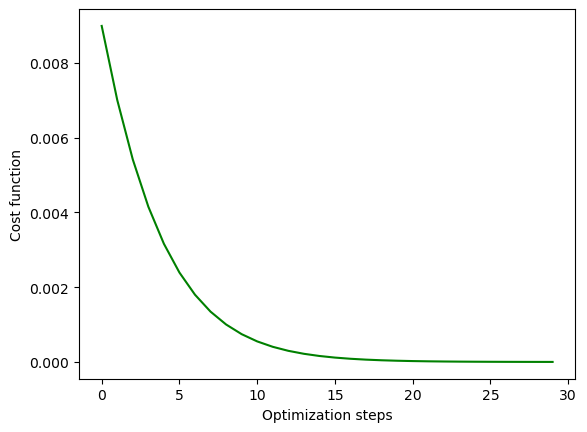

In [11]:
plt.plot(cost_history, "g")
plt.ylabel("Cost function")
plt.xlabel("Optimization steps")
plt.show()

In [12]:
# Classical comparison
Id = np.identity(2)
Z = np.array([[1, 0], [0, -1]])
X = np.array([[0, 1], [1, 0]])

A_0 = np.identity(8)
A_1 = np.kron(np.kron(X, Z), Id)
A_2 = np.kron(np.kron(X, Id), Id)

A_num = c[0] * A_0 + c[1] * A_1 + c[2] * A_2
b = np.ones(8) / np.sqrt(8)

In [13]:
A_inv = np.linalg.inv(A_num)
x = np.dot(A_inv, b)

c_probs = (x / np.linalg.norm(x)) ** 2

In [14]:
dev_x = qml.device("lightning.qubit", wires=n_qubits, shots=n_shots)

@qml.qnode(dev_x, interface="autograd")
def prepare_and_sample(weights):

    # Variational circuit generating a guess for the solution vector |x>
    variational_block(weights)

    # We assume that the system is measured in the computational basis.
    # then sampling the device will give us a value of 0 or 1 for each qubit (n_qubits)
    # this will be repeated for the total number of shots provided (n_shots)
    return qml.sample()

In [15]:
raw_samples = prepare_and_sample(w)

# convert the raw samples (bit strings) into integers and count them
samples = []
for sam in raw_samples:
    samples.append(int("".join(str(bs) for bs in sam), base=2))

q_probs = np.bincount(samples) / n_shots

In [23]:
import scipy.linalg as linalg

print("x_n^2 =\n", c_probs)
print("|<x|n>|^2=\n", q_probs)
print("Norm: ||x_n^2 -  |<x|n>|^2||\n", linalg.norm(c_probs - q_probs))

x_n^2 =
 [0.08445946 0.08445946 0.16554054 0.16554054 0.08445946 0.08445946
 0.16554054 0.16554054]
|<x|n>|^2=
 [0.084751 0.085048 0.165659 0.164629 0.084926 0.084891 0.164943 0.165153]
Norm: ||x_n^2 -  |<x|n>|^2||
 0.0014790011282864775


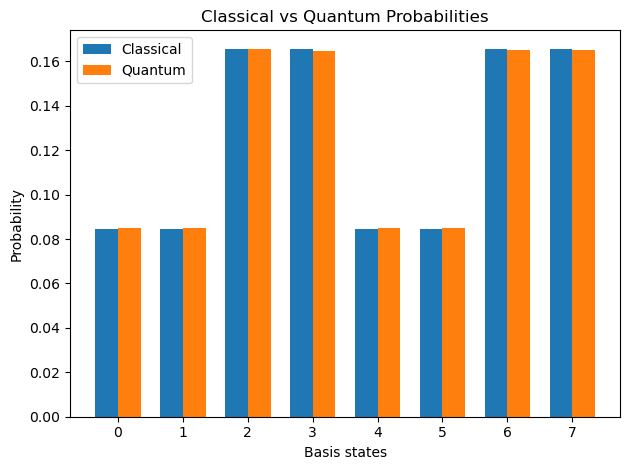

In [19]:
x = np.arange(2**n_qubits)
width = 0.35  # Width of the bars

plt.bar(x - width/2, c_probs, width, label='Classical')
plt.bar(x + width/2, q_probs, width, label='Quantum')

plt.xlabel('Basis states')
plt.ylabel('Probability')
plt.title('Classical vs Quantum Probabilities')
plt.xticks(x)
plt.legend()

plt.tight_layout()
plt.show()

2. (extra credit) Solve this problem using the HHL algorithm.

In [5]:
# TODO

### Problem C
Given the inhomogeneous linear system:
$$ \begin{align*} x_1 - x_2 + x_3 - x_4 &= 2 \\ x_1 - x_2 + x_3 + x_4 &= 0 \\ 4x_1 - 4x_2 + 4x_3 &= 4 \\ 2x_1 - 2x_2 + 2x_3 - x_4 &= 3 \end{align*} $$
Write this LSE in matrix form and decompose the coefficient matrix $A$ and vector $b$ to apply the VQLS algorithm and compare its result with the "classical" solutions.

In [27]:
# Set up the matrix A and vector b to find their Pauli decompositions
A = np.array([[1, -1, 1, -1],
              [1, -1, 1, 1],
              [4, -4, 4, 0],
              [2, -2, 2, -1]])
print(decompose_H_to_string(A))

b = np.array([[2],
              [0],
              [4],
              [3]])
print(decompose_H_to_string(b))

['0.75 * I^I', '0.5 * I^X', '-1j * I^Y', '1.75 * I^Z', '1 * X^I', '-0.5 * X^X', '-2j * X^Y', '1.5 * X^Z', '0.5j * Y^X', '-1 * Y^Y', '-1.5j * Y^Z', '-0.75 * Z^I', '-0.5 * Z^X', '-0.75 * Z^Z']
['0.5 * I^I', '0.5 * I^Z', '1 * X^I', '0.75 * X^X', '-0.75j * X^Y', '1 * X^Z', '-1j * Y^I', '-0.75j * Y^X', '-0.75 * Y^Y', '-1j * Y^Z', '0.5 * Z^I', '0.5 * Z^Z']


Using $\texttt{decompose\_Pauli}$ from $\texttt{VQE\_AHO.ipynb}$, we find the decompositions
\begin{align*}
  A &= 0.75 \mathbb{I} + 0.5 X_0 - i Y_0 + 1.75 Z_0 + X_1 - 0.5 X_1X_0 - 2i X_1Y_0 + 1.5 X_1Z_0 \\
  & \quad + 0.5i Y_1X_0 - Y_1Y_0 - 1.5i Y_1Z_0 - 0.75 Z_1 - 0.5 Z_1X_0 - 0.5 Z_1Z_0 \\
  b &= 0.5 \mathbb{I} + 0.5 Z_0 + X_1 + 0.75 X_1X_0 - 0.75i X_1Y_0 + X_1Z_0 \\
  & \quad - iY_1 - 0.75iY_1X_0 - 0.75Y_1Y_0 - iY_1Z_0 + 0.5Z_1 + 0.5Z_1Z_0
\end{align*}

In [ ]:
# TODO
